## 1. Pre-trained Conv-nets

Here we will show how to use an existing model of convolutional neural networks that are built into keras.
<br>There are several architectures exist that were trained on larget datasets of images (such as imagenet) and you can refer to them here [Keras website](https://keras.io/applications/).
<br>For each model there is a different input size of the images (224x224),(299x299),.... Thus to predict an image using them, you will need to resize it.

In [2]:
#Loading the model.

import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array

input_shape=(150,150)
target_model='VGG16'

if(target_model=='VGG16'):
    #from tensorflow.keras.applications import VGG16
    from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
    #First time calling this will download the entire model (~500MB)
    conv_net=VGG16()
    input_shape=(224,224)
elif (target_model=='InceptionV3'):
    #Inception model ~100MB
    from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
    conv_net=InceptionV3()
    input_shape=(299,299)

conv_net.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
#Starting local webcamera.
#make sure to install OpenCV library

import cv2
import numpy as np
#start webcamera
cam = cv2.VideoCapture(0)


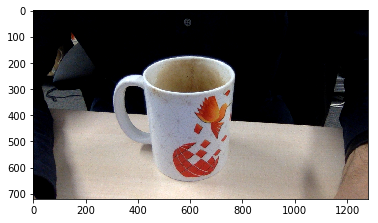

coffee_mug: 57.0%
pitcher: 13.0%
cup: 6.0%


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

#Read one image from the camera
ret, image = cam.read()
#display the image
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()

#Resize the image to the acceptable size of the model
image=cv2.resize(image, input_shape)
#create a copy of the image
img=img_to_array(image.copy())
#pre-process the image (Normalization)
img=preprocess_input(img) 
#predict the image
res=conv_net.predict(np.array([img]))
#convert predictions to labels
predictions=decode_predictions(res)[0]

#print top 3 predictions with their confidence values
for i in range(3):
    print("{0}: {1}%".format(predictions[i][1],round(predictions[i][2]*100)))


In [6]:
cam.release()

## 2. Visualizing what the network sees

We can visualize what the network "sees" by going through each of the layers (except the dense layers) and draw the activations for each filter of the convolution layers. 

This function basically extracts some of the layers from the network, create a new model with the same input, but the outputs are all layers of the network. Then, we predict the activations of all the layers for the target image

In [7]:

from tensorflow.keras import models

def VisualizeActivations(model,image,last_layer):
    #extract the layers
    layer_outputs=[layer.output for layer in model.layers[1:last_layer]]
    #create a new model
    activation_model=models.Model(inputs=model.input,outputs=layer_outputs)
    #activate layers filters
    activations=activation_model.predict(np.array([image]))


    layer_names=[]
    for layer_name in conv_net.layers:
        layer_names.append(layer_name.name)

    image_per_row=16

    for name,activation in zip(layer_names,activations):
        features=activation.shape[-1]
        size=activation.shape[1]

        cols=features//image_per_row
        display_grid=np.zeros((size*cols,size*image_per_row))

        for col in range(cols):
            for row in range(image_per_row):
                channel_img=activation[0,:,:,col*image_per_row+row]

                channel_img-=channel_img.mean()
                channel_img/=channel_img.std()
                channel_img*=64
                channel_img+=128
                channel_img=np.clip(channel_img,0,255).astype('uint8')
                display_grid[col*size:(col+1)*size, row*size:(row+1)*size]=channel_img


        scale=1./size
        plt.figure(figsize=(scale*display_grid.shape[1],scale*display_grid.shape[0]))
        plt.title(name)
        plt.grid(False)
        plt.imshow(display_grid,aspect='auto')
        plt.show()

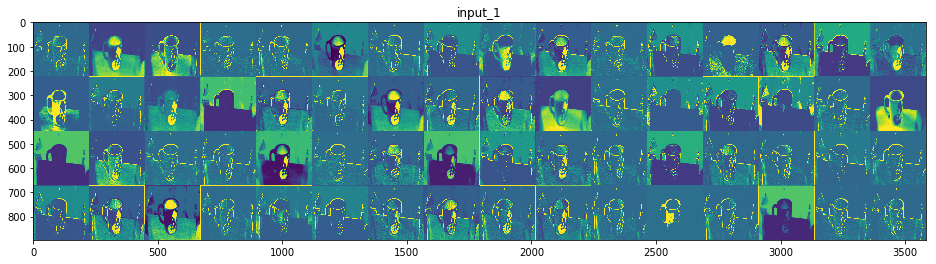

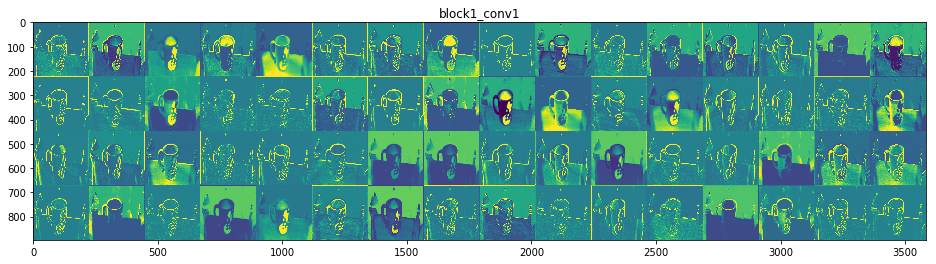

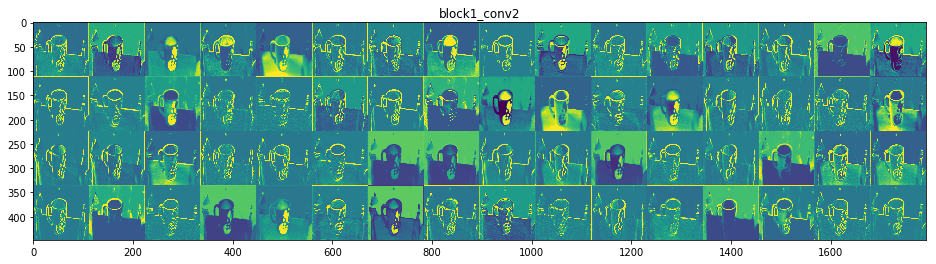

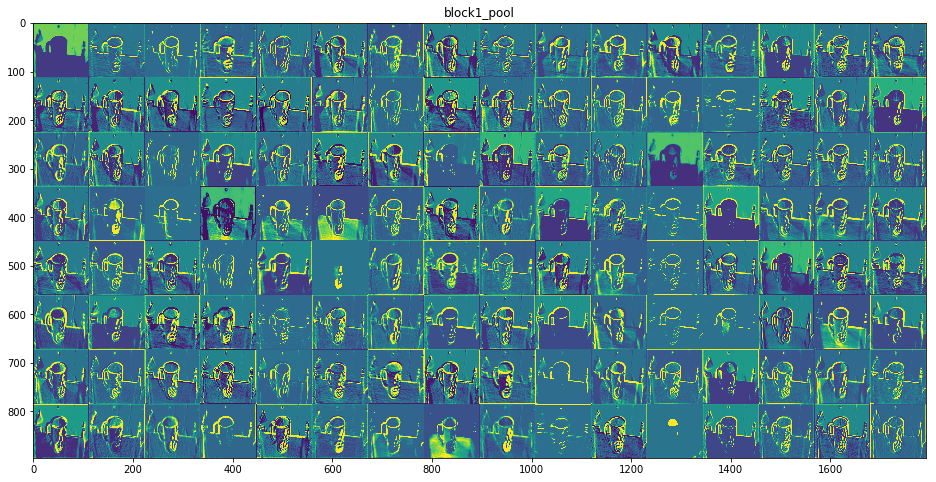

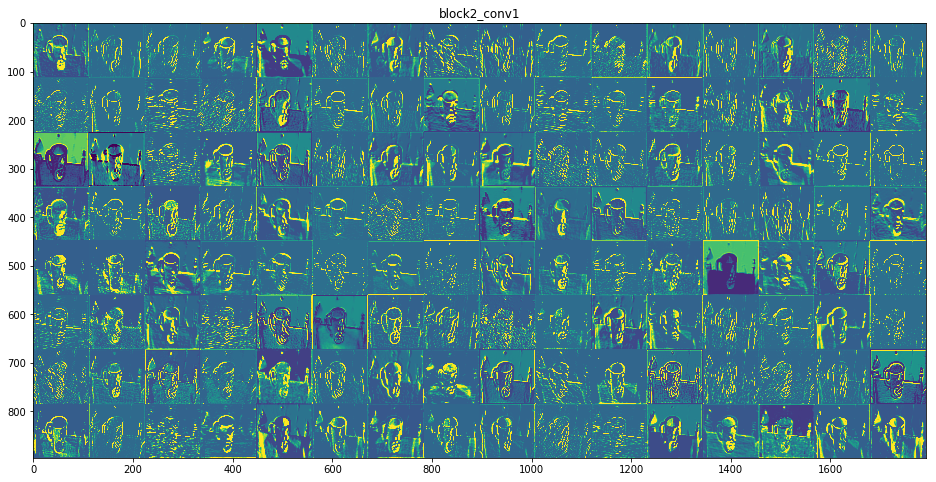

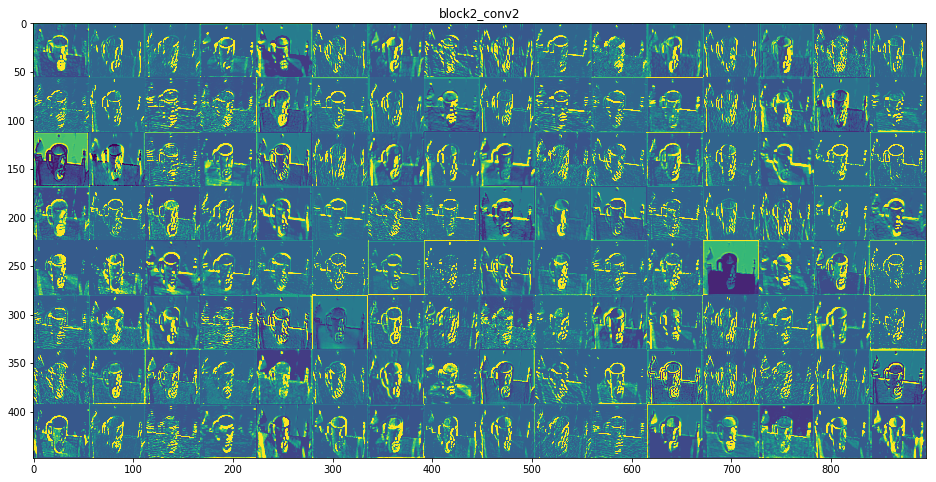

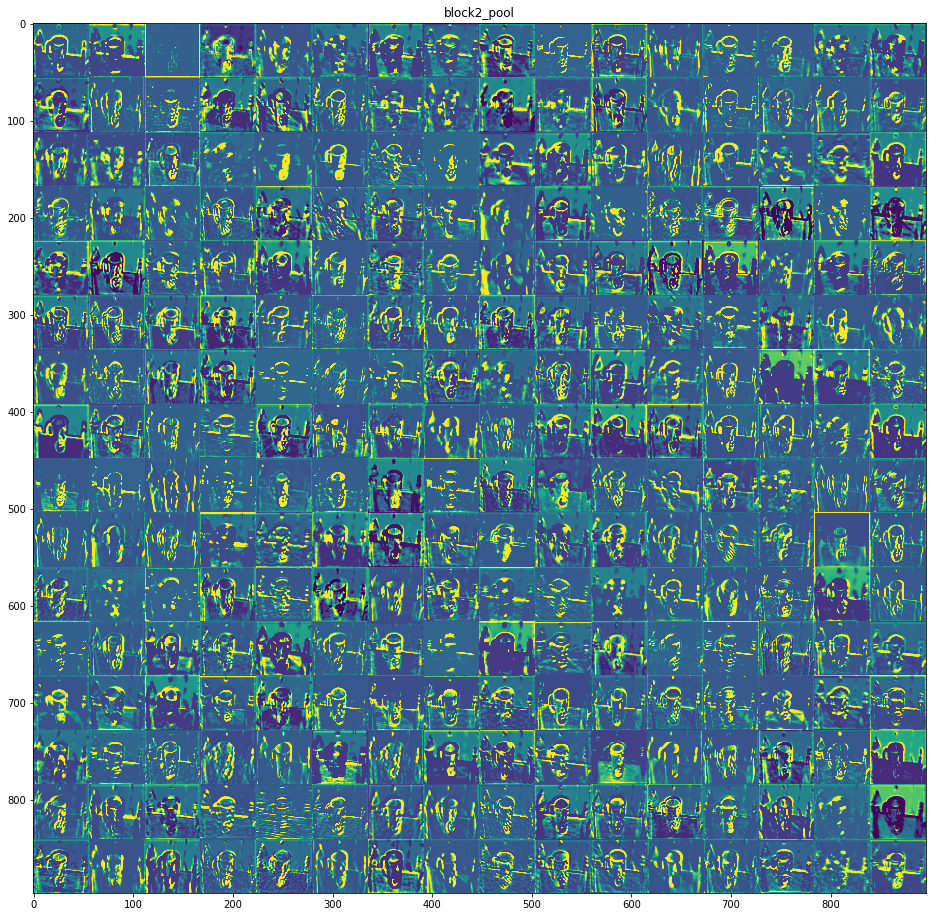

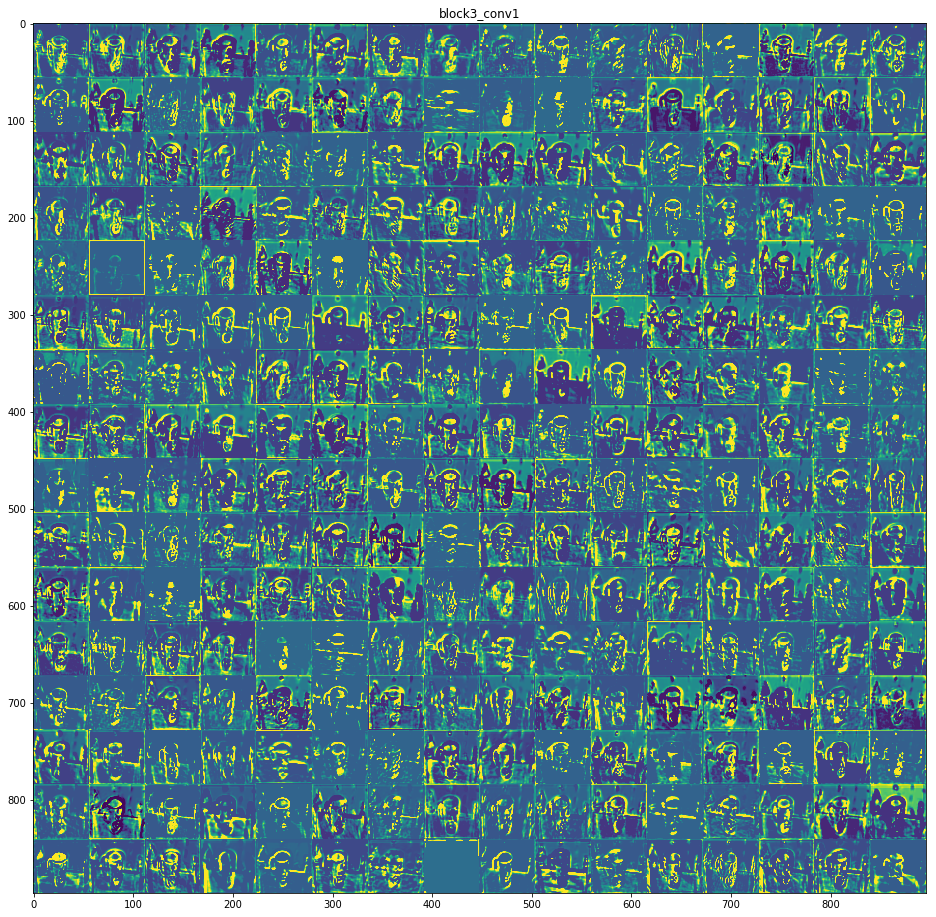

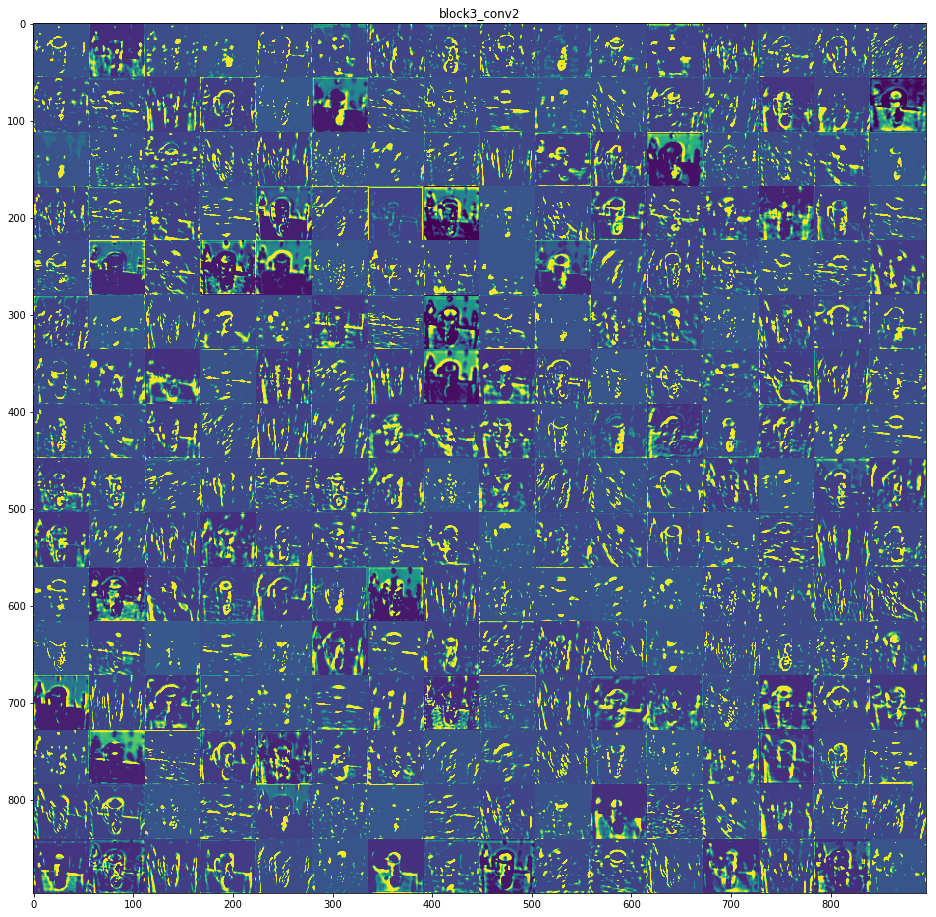

In [8]:
VisualizeActivations(conv_net,img,10)

## 3. Visualize the kernels of Conv-nets

Here we can visualize the filters of the network, to see which patterns each kernel activates for. 
<br>We use gradient descent to maximize the activation for each kernel

In [26]:
from tensorflow.keras import backend as K
import numpy as np

def convert_image(x):
    x-=x.mean()
    x/=(x.std()+1e-5)
    x*=0.2
    
    x+=0.5
    x=np.clip(x,0,1)
    
    x*=255
    x=np.clip(x,0,255).astype('uint8')
    return x

def generate_pattern(model,layer_name,filter_index,size=224,step=1.,epochs=30):
    layer_output=model.get_layer(layer_name).output
    loss=K.mean(layer_output[:,:,:,filter_index])#loss function
    
    grads=K.gradients(loss,model.input)[0]#gradients
    
    norm_grads=grads/(K.sqrt(K.mean(K.square(grads)))+1e-5)#normalized gradients

    calc_function=K.function([model.input],[loss,norm_grads])#calculate loss and gradients with regard to model input
    
    input_img_data=np.random.random((1,size,size,3))*30+128
    
    #gradient descent
    for i in range(epochs):
        loss_val,grads_val=calc_function([input_img_data])
        input_img_data += grads_val*step
        
    return convert_image(input_img_data[0])

def VisualizeLayerActivation(model,layer_name,count=3,epochs=30,size=32):
    margin=5

    results=np.zeros((count*size+(count-1)*margin,count*size+(count-1)*margin,3))

    for i in range(count):
        for j in range(count):
            index=(j+(i*count))
            img=generate_pattern(model,layer_name,index,size=size,step=1,epochs=epochs)

            x=i*(size+margin)
            y=j*(size+margin)
            results[x:x+size,y:y+size,:]=img

    plt.figure(figsize=(10,10))
    plt.imshow(results.astype('uint8'))

In [27]:
conv_net.summary()#print the layer names

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

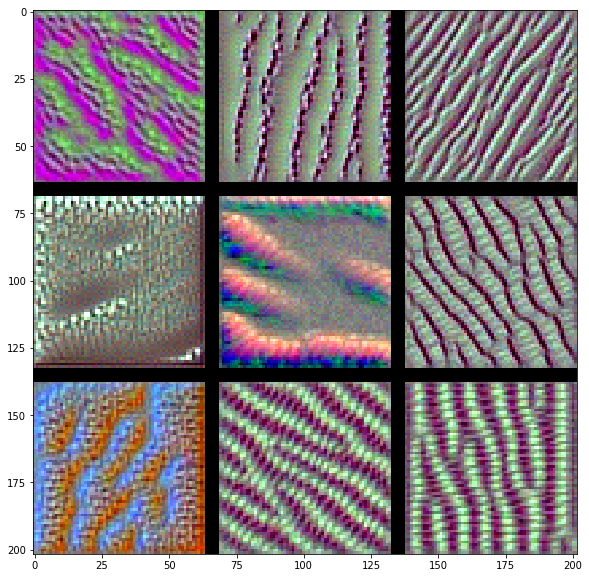

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

VisualizeLayerActivation(conv_net,'block2_conv2',count=3,epochs=40,size=64)